# Noisy label detection for detection tasks from training loss dynamics statistics

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/13_noisy_label_detection_det.ipynb)

This tutorial covers how to find noisy labeled samples in the training dataset while training the model on your dataset. This feature utilizes both [Datumaro](https://github.com/openvinotoolkit/datumaro) and [OpenVINO™ Training Extensions](https://github.com/openvinotoolkit/training_extensions) simultaneously.

## Prerequisite
### Download Six-sided Dice dataset
This is [a download link for Six-sided Dice dataset in Kaggle](https://www.kaggle.com/datasets/nellbyler/d6-dice?resource=download). Please download using this link and extract to your workspace directory. Then, you will have a `d6-dice` directory with annotations and images in YOLO format as follows.

```bash
d6-dice
├── Annotations
│   ├── classes.txt
│   ├── IMG_20191208_111228.txt
│   ├── IMG_20191208_111246.txt
│   ├── ...
└── Images
    ├── IMG_20191208_111228.jpg
    ├── IMG_20191208_111246.jpg
    ├── ...
```

However, for import compatibility, `obj.names` file must be added to `d6-dice/obj.names` filepath for import compatibility. This `obj.names` file includes the label names of the dataset, e.g., `[dice1, ..., dice6]`. Therefore, you can write it with the following simple code. Please see [Yolo Loose format](https://openvinotoolkit.github.io/datumaro/latest/docs/explanation/formats/yolo) for more details.

In [ ]:
# Copyright (C) 2023 Intel Corporation
#
# SPDX-License-Identifier: MIT

import os

root_dir = "d6-dice"

names = """
dice1
dice2
dice3
dice4
dice5
dice6
"""

fpath = os.path.join(root_dir, "obj.names")
with open(fpath, "w") as fp:
    fp.write(names)

### Install OpenVINO™ Training Extensions
For more details, please see this [OpenVINO™ Training Extensions installation guide](https://openvinotoolkit.github.io/training_extensions/latest/guide/get_started/quick_start_guide/installation.html).

In [ ]:
!pip install otx

## Synthesize noisy label using Datumaro Python API

In this section, we utilize the Datumaro Python API to synthesize noisy label samples. We import the d6-dice dataset and apply dataset transforms for subsequent stages. Initially, we divide the dataset into three subsets: train, val, and test. Subsequently, we employ the `reindex_annotations` transform to assign a unique ID to each bounding box annotation. This transform is crucial as it enables us to monitor the training loss dynamics for each bounding box. It ensures that bboxes with the same ID remain distinct from one another.

In [1]:
import datumaro as dm

dataset = dm.Dataset.import_from("d6-dice", format="yolo")
dataset.transform("random_split", splits=[("train", 0.5), ("val", 0.2), ("test", 0.3)])
dataset.transform("reindex_annotations")
dataset

Dataset
	size=250
	source_path=d6-dice
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=250
	annotations_count=1795
subsets
	test: # of items=75, # of annotated items=75, # of annotations=507, annotation types=['bbox']
	train: # of items=125, # of annotated items=125, # of annotations=952, annotation types=['bbox']
	val: # of items=50, # of annotated items=50, # of annotations=336, annotation types=['bbox']
infos
	categories
	label: ['dice1', 'dice2', 'dice3', 'dice4', 'dice5', 'dice6']

### Synthesize incorrect label samples

We synthesize 4 training samples to have randomly incorrect labels. For each sample, we will randomly change the label of one bounding box. You can see through Datumaro's visualizer that one dice eye is replaced with another eye for each sample as follows.

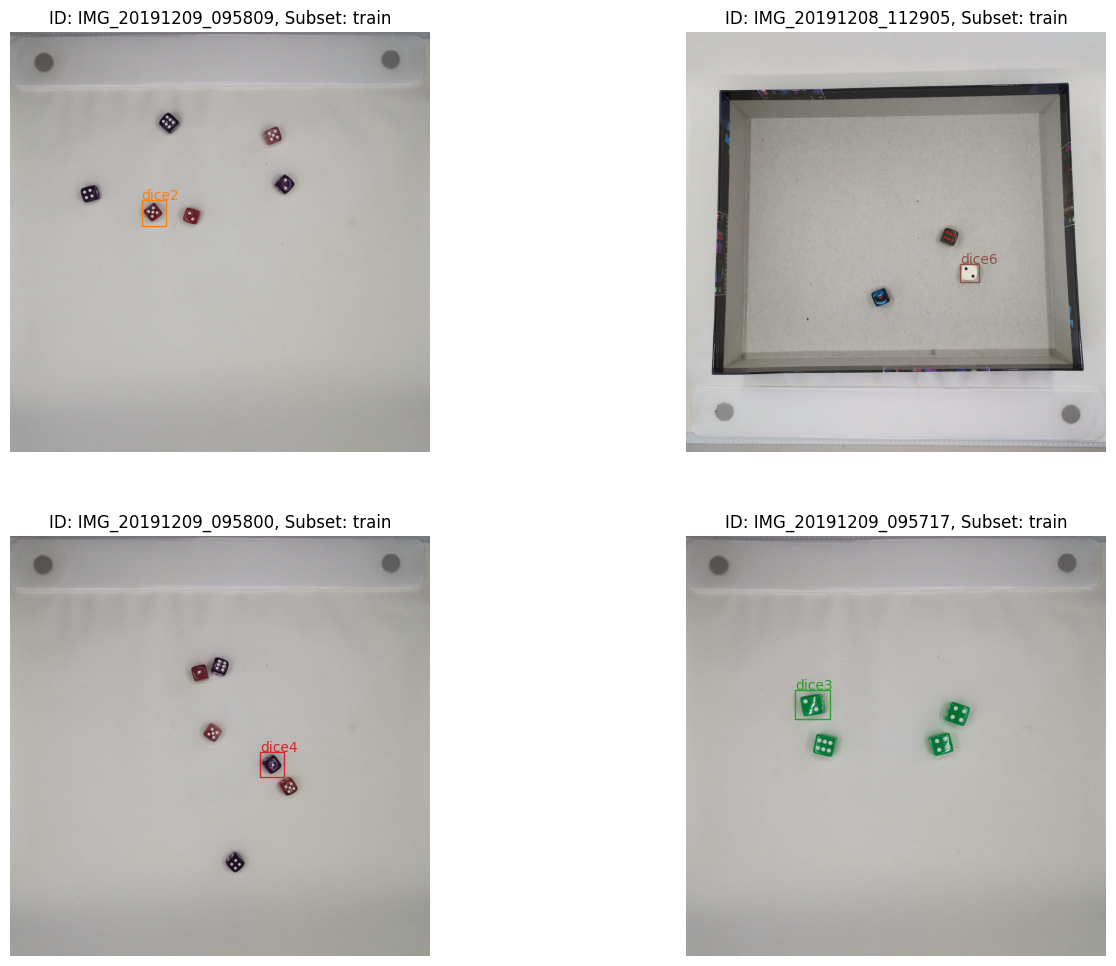

In [2]:
import random

random.seed(3003)

n_noisy_anns = 4
label_categories = dataset.categories()[dm.AnnotationType.label]
training_items = [item for item in dataset if item.subset == "train"]

random.shuffle(training_items)

syn_noisy_ids = []

for item in training_items[:n_noisy_anns]:
    ann = random.choice(item.annotations)

    new_label_id = random.choice(range(len(label_categories)))
    while new_label_id == ann.label:
        new_label_id = random.choice(range(len(label_categories)))

    ann.label = new_label_id

    syn_noisy_ids += [(item.id, ann.id)]

viz = dm.Visualizer(dataset, figsize=(16, 12))
fig = viz.vis_gallery(*list(zip(*syn_noisy_ids)), "train")
fig.show()

We export this synthesized noisy label dataset to train the model with OpenVINO™ Training Extensions with tracking training loss dynamics for noisy label detection.

In [3]:
dataset.export("d6-dice-noisy", format="datumaro_binary", save_media=True)

### Train a model and export training loss dynamics statistics using OpenVINO™ Training Extensions

In this step, we train a classification model using OpenVINO™ Training Extensions. To see the detail guides for OpenVINO™ Training Extensions usage, please see [How-To-Train](https://openvinotoolkit.github.io/training_extensions/latest/guide/tutorials/base/how_to_train/classification.html). In this example, we use the CLI command to train the model. Adding the argument `params --algo_backend.enable_noisy_label_detection True` at the end allows you to export training loss dynamics statistics at the end of training.

In [ ]:
!otx train Custom_Object_Detection_Gen3_ATSS \
    --train-data-roots d6-dice-noisy \
    --val-data-roots d6-dice-noisy \
    -o outputs \
    params --algo_backend.enable_noisy_label_detection True

### Import statistics and analyze them to find the noisy label samples

In this step, we import the statistics obtained during the model training to find the noisy label samples. Because we set the output directory as `outputs` in the previous step, we you can find the dataset including statistics which is exported to [Datumaro format](https://openvinotoolkit.github.io/datumaro/latest/docs/explanation/formats/datumaro) at `outputs/logs/noisy_label_detection`. To make training loss dynamics analysis easier, we provide an interface called `dm.LossDynamicsAnalyzer`. You can get the top-k candidates for noisy label samples using it. Additionally, we can also plot the exponential moving average (EMA) training loss curves of top-k candidates and compare them with the average of samples in the dataset. The EMA training loss is a very strong criterion for noisy label samples. For more detail, please see [1].

[1]: Zhou, Tianyi, Shengjie Wang, and Jeff Bilmes. "Robust curriculum learning: from clean label detection to noisy label self-correction." International Conference on Learning Representations. 2021.

Since we synthesized noisy labeled samples by changing their labels, we should set `tracking_loss_type` as `cls`.

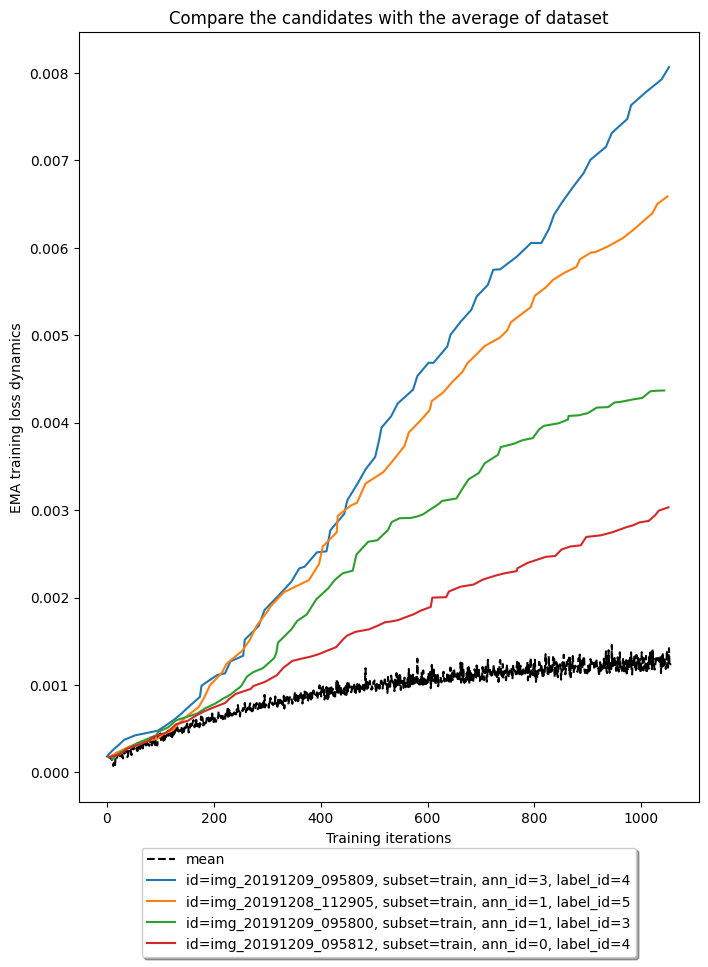

In [9]:
# Import the exported statistics
stats = dm.Dataset.import_from("outputs/logs/noisy_label_detection", format="datumaro")
analyzer = dm.LossDynamicsAnalyzer(stats, tracking_loss_type="cls")

# Get top-k candidates
cands = analyzer.get_top_k_cands(4)

# Plot the top-k candidates EMA loss dynamics with the dataset average
fig = analyzer.plot_ema_loss_dynamics(cands, figsize=(8, 10), mode="mean")
fig.show()

To take a closer look at the noisy label candidates, we use `dm.Visualizer` to plot the images and labels in a gallery format. We can see there are many samples that we previously synthesized to have noisy labels.

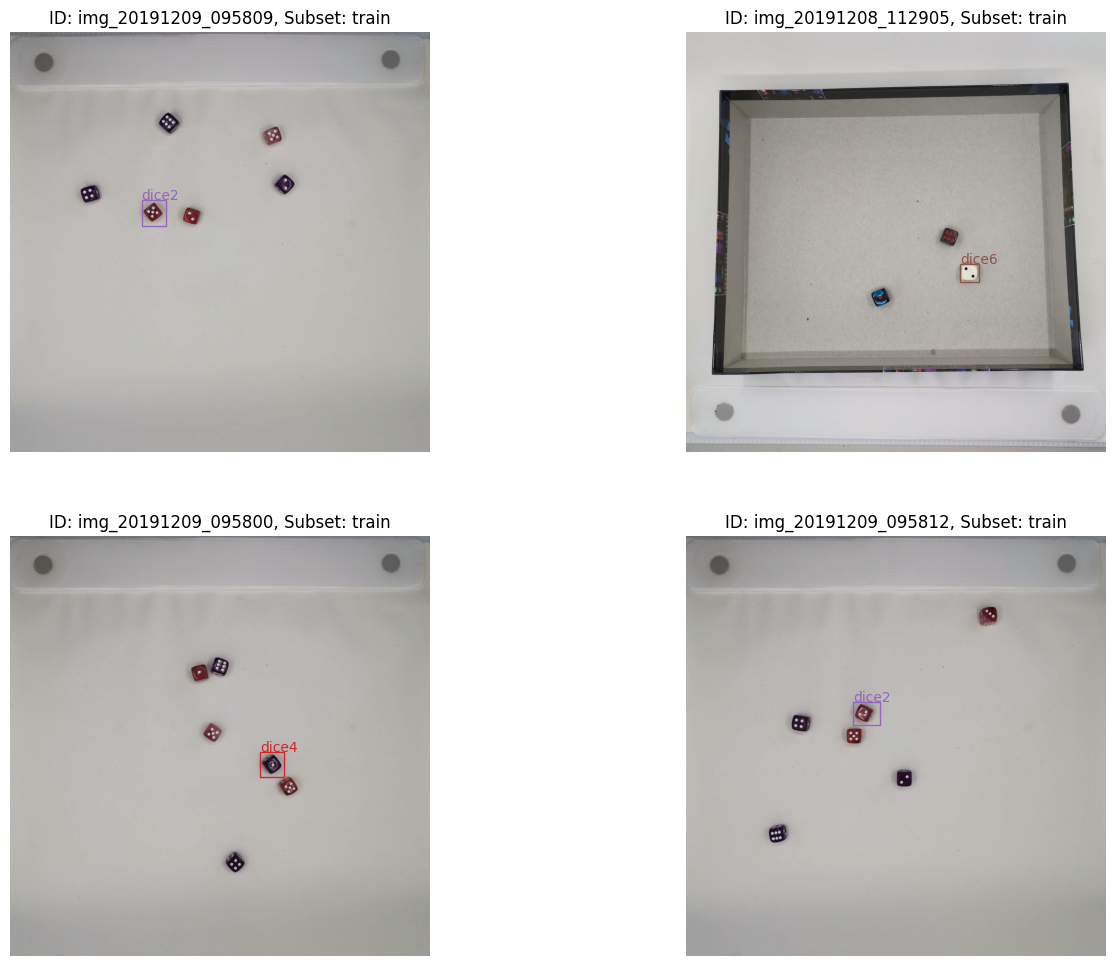

In [10]:
viz = dm.Visualizer(stats, figsize=(16, 12))
fig = viz.vis_gallery([cand.id for cand in cands], [cand.ann_id for cand in cands], "train")
fig.show()

In the last step, we calculate the quantitative scores for our noisy label detection algorithm. The accuracy and recall values for noisy label detection are obtained as follows.

In [21]:
detect_noisy_ids = {cand.id for cand in cands}
intersection = detect_noisy_ids.intersection({item_id.lower() for item_id, _ in syn_noisy_ids})

accuracy = 100.0 * len(intersection) / len(cands)
recall = 100.0 * len(intersection) / len(syn_noisy_ids)

print(f"Accuracy = {accuracy:.1f}% and Recall = {recall:.1f}%")

Accuracy = 75.0% and Recall = 75.0%
